# DEAM Dataset - regresja i klasyfikacja na podstawie gotowych cech ze zbioru

In [3]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Pobieranie zbioru danych i ścieżki do folderów

In [2]:
path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")
print(path)
features_path = os.path.join(path, 'features', 'features')
arousal_file = os.path.join(path, 'DEAM_Annotations', 'annotations', 'annotations averaged per song',
                       'dynamic (per second annotations)', 'arousal.csv')
valence_file = os.path.join(path, 'DEAM_Annotations', 'annotations', 'annotations averaged per song',
                       'dynamic (per second annotations)', 'valence.csv')

C:\Users\Gabi\.cache\kagglehub\datasets\imsparsh\deam-mediaeval-dataset-emotional-analysis-in-music\versions\1


Przetwarzanie danych i zapis do ramki do pliku - adnotacje dynamiczne (wiele adnotacji do jednej piosenki - co sekundę)
<br>
Mapowanie emocji - valence i arousal w skali ok. -0,75 - 0,75 i podział na cztery ćwiartki, gdzie 0 jest w środku. Emocje:
- happy, gdy valence > 0 oraz arousal > 0,
- relaxed, gdy valence > 0 a arousal < 0,
- sad, gdy i valence i arousal < 0,
- angry, gdy valence < 0 a arousal > 0.

In [3]:
df_all = []

valence = pd.read_csv(valence_file, delimiter=',').set_index('song_id')
arousal = pd.read_csv(arousal_file, delimiter=',').set_index('song_id')

for file in os.listdir(features_path):
    song_id = int(file.split('.')[0])
    song = pd.read_csv(f'{features_path}/{file}', delimiter=';')
    song.insert(0, 'song_id', song_id)
    song = song[song.frameTime >= 15]

    valence_list = valence[valence.index == song_id].to_numpy().tolist()[0][:len(song)]
    arousal_list = arousal[arousal.index == song_id].to_numpy().tolist()[0][:len(song)]
    song.insert(2, 'valence', valence_list)
    song.insert(3, 'arousal', arousal_list)

    song = song.dropna().reset_index(drop=True)
    df_all.append(song)

df = pd.concat(df_all, ignore_index=True)

conditions = [
    (df['valence'] > 0) & (df['arousal'] > 0),
    (df['valence'] > 0) & (df['arousal'] < 0),
    (df['valence'] < 0) & (df['arousal'] < 0),
    (df['valence'] < 0) & (df['arousal'] > 0)
]
choices = ['happy', 'relaxed', 'sad', 'anger']
df['emotion'] = np.select(conditions, choices, default=None)
first = df.pop('emotion')
df.insert(4, 'emotion', first)

df.reset_index(drop=True, inplace=True)
df.to_pickle('resources/DEAM_dynamic.pickle')
df.shape

(127966, 265)

In [2]:
df = pd.read_pickle('../resources/DEAM_dynamic.pickle')
df

,song_id,frameTime,valence,arousal,emotion,F0final_sma_stddev,F0final_sma_amean,voicingFinalUnclipped_sma_stddev,voicingFinalUnclipped_sma_amean,jitterLocal_sma_stddev,...,pcm_fftMag_mfcc_sma_de[10]_stddev,pcm_fftMag_mfcc_sma_de[10]_amean,pcm_fftMag_mfcc_sma_de[11]_stddev,pcm_fftMag_mfcc_sma_de[11]_amean,pcm_fftMag_mfcc_sma_de[12]_stddev,pcm_fftMag_mfcc_sma_de[12]_amean,pcm_fftMag_mfcc_sma_de[13]_stddev,pcm_fftMag_mfcc_sma_de[13]_amean,pcm_fftMag_mfcc_sma_de[14]_stddev,pcm_fftMag_mfcc_sma_de[14]_amean
0,10,15.0,0.091968,-0.129007,relaxed,96.07264,147.35590,0.028202,0.798873,0.076858,...,1.793648,0.147457,2.140625,-0.008783,2.191616,0.063937,1.712658,0.104018,1.492482,0.056986
1,10,15.5,0.095412,-0.132931,relaxed,151.16670,295.13900,0.053860,0.819231,0.069150,...,2.951750,-0.142590,2.448553,0.195778,2.199358,0.301697,1.969837,-0.034356,1.632862,-0.019636
2,10,16.0,0.095003,-0.138653,relaxed,148.98030,396.36610,0.059307,0.831506,0.083793,...,3.188626,0.116345,2.863296,0.390074,1.995971,0.483819,1.971488,-0.057783,2.163724,-0.391978
3,10,16.5,0.096409,-0.139502,relaxed,139.34050,422.96440,0.045554,0.854269,0.079606,...,1.888213,0.127083,2.979870,0.164326,2.109437,0.149199,1.466699,0.262548,2.717078,0.236175
4,10,17.0,0.095090,-0.142657,relaxed,113.54910,411.41420,0.057506,0.844544,0.037989,...,2.588508,-0.058506,3.449312,-0.172044,2.973296,-0.351113,2.464581,0.084045,2.541161,0.334147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127961,999,42.5,0.294348,-0.154865,relaxed,22.63366,102.38560,0.023686,0.765310,0.150767,...,1.879818,-0.096140,1.553450,0.038923,1.445847,0.054145,1.375260,-0.166373,0.940085,-0.025368
127962,999,43.0,0.294940,-0.155621,relaxed,27.82557,100.74620,0.027255,0.771397,0.131389,...,1.719540,-0.114137,1.562314,-0.035108,1.318819,-0.060422,1.693078,0.055705,1.190915,0.107324
127963,999,43.5,0.296522,-0.155486,relaxed,31.67118,96.38049,0.026829,0.764021,0.132454,...,1.528162,0.093345,1.738730,-0.203497,1.300053,-0.008531,1.467194,0.203070,1.466039,-0.007787
127964,999,44.0,0.294336,-0.161148,relaxed,38.64713,104.26730,0.022817,0.746685,0.128434,...,1.667937,0.095988,2.022442,0.015252,1.097400,0.123531,1.111899,0.111450,1.384199,-0.151243


Wizualizacja valence i arousal dla jednej piosenki

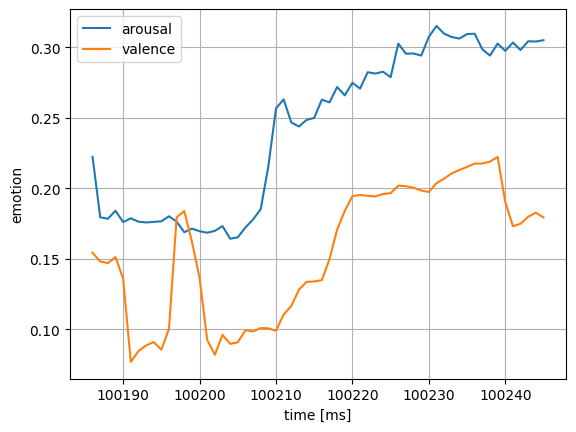

In [5]:
df_10 = df[df['song_id'] == 4]
plt.plot(df_10['arousal'], label='arousal')
plt.plot(df_10['valence'], label='valence')
plt.xlabel("time [ms]")
plt.ylabel("emotion")
plt.legend()
plt.grid(True)
plt.show()

Histogramy dla valence i arousal

[]

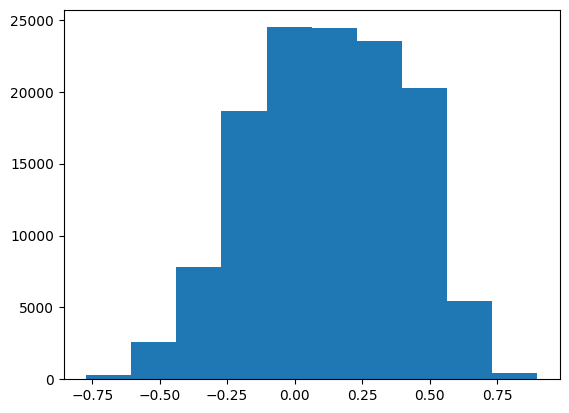

In [6]:
plt.hist(df['arousal'], label='arousal')
plt.plot()

[]

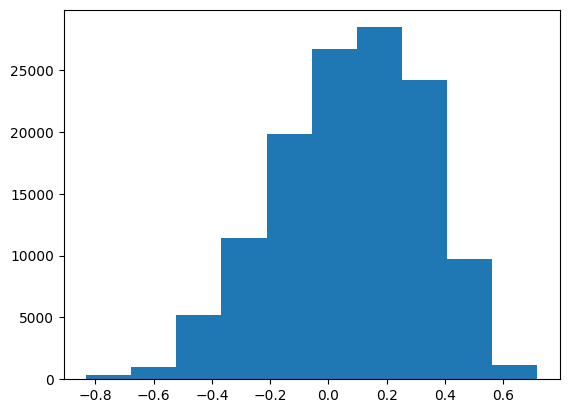

In [7]:
plt.hist(df['valence'], label='valence')
plt.plot()

Rozkład emocji - w liczbach oraz procentach

In [8]:
df['emotion'].value_counts()

emotion
happy      62868
sad        27297
anger      20100
relaxed    17627
Name: count, dtype: int64

In [9]:
df['emotion'].value_counts(normalize=True) * 100

emotion
happy      49.157101
sad        21.343790
anger      15.716386
relaxed    13.782723
Name: proportion, dtype: float64

Rozkład klas jest nierównomierny, ale na razie próba uczenia na takim oryginalnym zbiorze

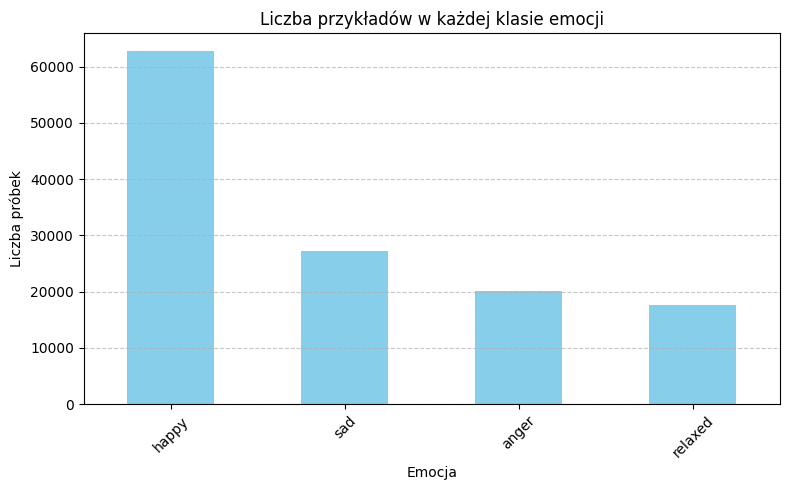

In [10]:
emotion_counts = df['emotion'].value_counts()

plt.figure(figsize=(8, 5))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Liczba przykładów w każdej klasie emocji')
plt.xlabel('Emocja')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Podział piosenek na sekwencje - traktujemy jedną piosenkę jako jedną sekwencję o długości 58 "pomiarów". Na początki brane były z jednej piosenki po kolei wiele sekwencji, jednak uczenie trwało bardzo długo i dawało jeszcze gorsze rezultaty.

In [4]:
sequence_length=58
def divide_into_sequences(dataframe, feature_cols): # ok. 30 sekund utworu (27)
    X, y, emotions, ids = [], [], [], []
    # Grupowanie po piosence
    happy_number = 0
    for song_id, group in dataframe.groupby('song_id'):
        group = group.reset_index(drop=True)
        features = group[feature_cols].to_numpy()
        targets = group[['valence', 'arousal']].to_numpy()
        emotion = group['emotion'].iloc[0]
        if emotion == 'happy':
            happy_number += 1
            if happy_number > 380:
                continue

        # Pomijamy piosenki krótsze niż sekwencja
        if len(group) < sequence_length:
            print(song_id)
            continue

        # for i in range(len(group) - sequence_length + 1):
        X.append(features[0 : sequence_length])
        y.append(targets[0 : sequence_length])
        emotions.append(emotion)
        ids.append(song_id)

    X = np.array(X)  # shape: (num_sequences, sequence_length, num_features)
    y = np.array(y)  # shape: (num_sequences, sequence_length, 2)
    return X, y, emotions, ids

1 802 piosenek, dla każdej sekwencja ma długość 58, 260 cech oraz 2 wartości y

In [117]:
feature_cols = [col for col in df.columns if col not in ['song_id', 'valence', 'arousal', 'frameTime', 'emotion']]
X, y, emotions = divide_into_sequences(df, feature_cols)
print(X.shape)
print(y.shape)
print(len(emotions))

(1802, 58, 260)
(1802, 58, 2)
1802


Podział sekwencji na zbiór treningowy i testowy wg id utworów, aby uczenie i walidacja były wiarygodne i nie pojawiła się sytuacja, że model uczył się na części danych z piosenki x, a potem w zbiorze testowym przewiduje inne dane z tej samej piosenki x - będą one w większości przypadków podobne.

In [5]:
def split_data(X, y, emotions, song_ids):
    # song_ids = df['song_id'].unique()
    train_ids, test_ids = train_test_split(song_ids, test_size=0.2, random_state=42)

    # Filtrowanie sekwencji
    X_train, y_train, emotions_train, X_test, y_test, emotions_test = [], [], [], [], [], []

    for i in range(len(X)):
        # seq_song_id = df.loc[df['song_id'] == song_ids[i // (len(df) // len(song_ids))], 'song_id'].values[0]
        seq_song_id = song_ids[i]
        if seq_song_id in train_ids:
            X_train.append(X[i])
            y_train.append(y[i])
            emotions_train.append(emotions[i])
        else:
            X_test.append(X[i])
            y_test.append(y[i])
            emotions_test.append(emotions[i])

    X_train, y_train, emotions_train = np.array(X_train), np.array(y_train), emotions_train
    X_test, y_test, emotions_test = np.array(X_test), np.array(y_test), emotions_test
    return X_train, y_train, emotions_train, X_test, y_test, emotions_test

In [119]:
X_train, y_train, emotions_train, X_test, y_test, emotions_test = split_data(X, y, emotions)
print(X_train.shape)
print(len(emotions_train))
print(X_test.shape)
print(len(emotions_test))

(1731, 58, 260)
1731
(71, 58, 260)
71


Badania dla danych bez normalizacji - brak zmiany ilości przykładów z danej klasy.

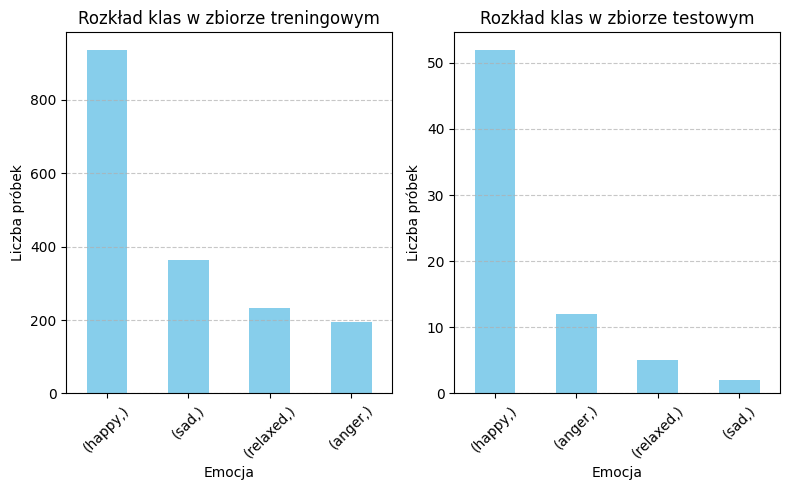

In [120]:
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
emotion_counts = pd.DataFrame(emotions_train).value_counts()
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Rozkład klas w zbiorze treningowym')
plt.xlabel('Emocja')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.subplot(1, 2, 2)
emotion_counts = pd.DataFrame(emotions_test).value_counts()
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Rozkład klas w zbiorze testowym')
plt.xlabel('Emocja')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Trenowanie modelu RNN - prosty model sekwencyjny

In [102]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(feature_cols))),
    TimeDistributed(Dense(32, activation='relu')),
    TimeDistributed(Dense(2))  # valence + arousal
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20


C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.1159 - val_loss: 0.0800
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0741 - val_loss: 0.0669
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0675 - val_loss: 0.0685
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0647 - val_loss: 0.0758
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0646 - val_loss: 0.0724
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0593 - val_loss: 0.0665
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0656 - val_loss: 0.0638
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0606 - val_loss: 0.0516
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0630 - val_loss: 0.0739
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0626 - val_loss: 0.0705
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0616 - val_loss: 0.0699
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0606 - val_l

Ewaluacja modelu - liczenie błędów regresji, potem zamiana na podstawie przybliżonych wartości na klasy emocji i liczenie błędów klasyfikacji, a na końcu przykład działania dla konkretnej próbki.
<br>
Błędy regresji są całkiem niskie, wydają się być przyzwoite. Jednak raport klasyfikacji i macierz konfuzji pokazują, że model głównie nauczył się rozpoznawać emocje radosne, bo jest ich najwięcej w zbiorze. Nie radzi sobie z rozpoznaniem pozostałych emocji.

In [6]:
def classify_emotion(valence, arousal):
    if valence > 0 and arousal > 0:
        return 'happy'
    if valence > 0 and arousal < 0:
        return 'relaxed'
    if valence < 0 and arousal < 0:
        return 'sad'
    if valence < 0 and arousal > 0:
        return 'anger'
    return 'indifferent'

In [7]:
def evaluate_model(y_test, emotions_test, y_pred, probe_number=3):
    # flattenujemy predykcje i rzeczywiste wartości (bo mamy sekwencje)
    mse_valence = mean_squared_error(y_test[:, :, 0].flatten(), y_pred[:, :, 0].flatten())
    mse_arousal = mean_squared_error(y_test[:, :, 1].flatten(), y_pred[:, :, 1].flatten())
    print("REGRESSION ERRORS")
    print("-------------------------------------")
    print(f"MSE Valence: {mse_valence:.4f}")
    print(f"MSE Arousal: {mse_arousal:.4f}")
    print("-------------------------------------")

    mae_valence = mean_absolute_error(y_test[:, :, 0].flatten(), y_pred[:, :, 0].flatten())
    mae_arousal = mean_absolute_error(y_test[:, :, 1].flatten(), y_pred[:, :, 1].flatten())
    print(f"MAE Valence: {mae_valence:.4f}")
    print(f"MAE Arousal: {mae_arousal:.4f}")
    print("-------------------------------------")

    r2_valence = r2_score(y_test[:, :, 0].flatten(), y_pred[:, :, 0].flatten())
    r2_arousal = r2_score(y_test[:, :, 1].flatten(), y_pred[:, :, 1].flatten())
    print(f"R² Valence: {r2_valence:.4f}")
    print(f"R² Arousal: {r2_arousal:.4f}")
    print("-------------------------------------")

    print("CLASSIFICATION ACCURACY\n")

    classification_pred = []
    classification_true = []
    for i in range(len(y_test)):
        pred_vals = y_pred[i]
        valence_mean = np.mean(pred_vals[:, 0])
        arousal_mean = np.mean(pred_vals[:, 1])

        classification_pred.append(classify_emotion(valence_mean, arousal_mean))
        classification_true.append(emotions_test[i])

    print(classification_report(classification_true, classification_pred))
    conusion_matrix = confusion_matrix(classification_true, classification_pred)

    ax= plt.subplot()
    sns.heatmap(conusion_matrix, annot=True, cmap='Blues')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(np.unique(classification_true))
    ax.yaxis.set_ticklabels(np.unique(classification_true))

    print("-------------------------------------")
    print("EVALUATION OF ONE SONG (SEQUENCE)\n")
    true_vals = y_test[probe_number]
    pred_vals = y_pred[probe_number]

    valence_mean_true = np.mean(true_vals[:, 0])
    arousal_mean_true = np.mean(true_vals[:, 1])
    emotion_true = emotions_test[probe_number]

    valence_mean = np.mean(pred_vals[:, 0])
    arousal_mean = np.mean(pred_vals[:, 1])
    emotion_pred = classify_emotion(valence_mean, arousal_mean)

    print(f"Results for probe no {probe_number}:")
    print(f"True emotion: {emotion_true}")
    print(f"True valence: {valence_mean_true:.4f}, true arousal: {arousal_mean_true:.4f}")
    print(f"Predicted emotion: {emotion_pred}")
    print(f"Predicted valence: {valence_mean:.4f}, predicted arousal: {arousal_mean:.4f}")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(true_vals[:, 0], label="True Valence")
    plt.plot(pred_vals[:, 0], label="Predicted Valence", linestyle="--")
    plt.legend()
    plt.title("Valence")

    plt.subplot(1, 2, 2)
    plt.plot(true_vals[:, 1], label="True Arousal")
    plt.plot(pred_vals[:, 1], label="Predicted Arousal", linestyle="--")
    plt.legend()
    plt.title("Arousal")

    plt.tight_layout()
    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0464
MSE Arousal: 0.0923
-------------------------------------
MAE Valence: 0.1684
MAE Arousal: 0.2635
-------------------------------------
R² Valence: -0.1640
R² Arousal: -0.8931
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       anger       0.29      0.67      0.40        12
       happy       0.82      0.62      0.70        52
     relaxed       0.00      0.00      0.00         5
         sad       0.25      0.50      0.33         2

    accuracy                           0.58        71
   macro avg       0.34      0.45      0.36        71
weighted avg       0.66      0.58      0.59        71

['anger' 'happy' 'relaxed' 'sad']
['anger' 'happy' 'sad']
-------------------------------------
EVALUATION OF ONE SONG (SEQUENCE)

Results for probe no 3:
True emotion: happy
True valence: 0.3959, true arousal: 0

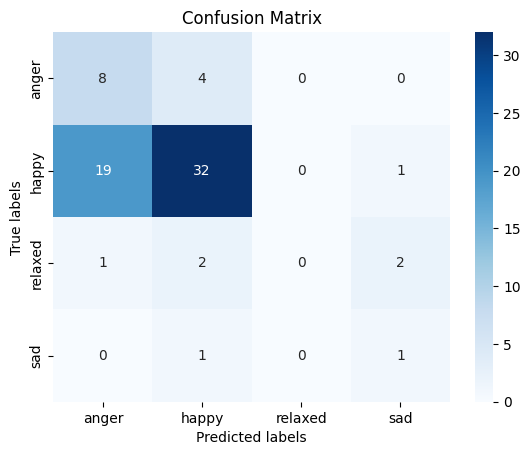

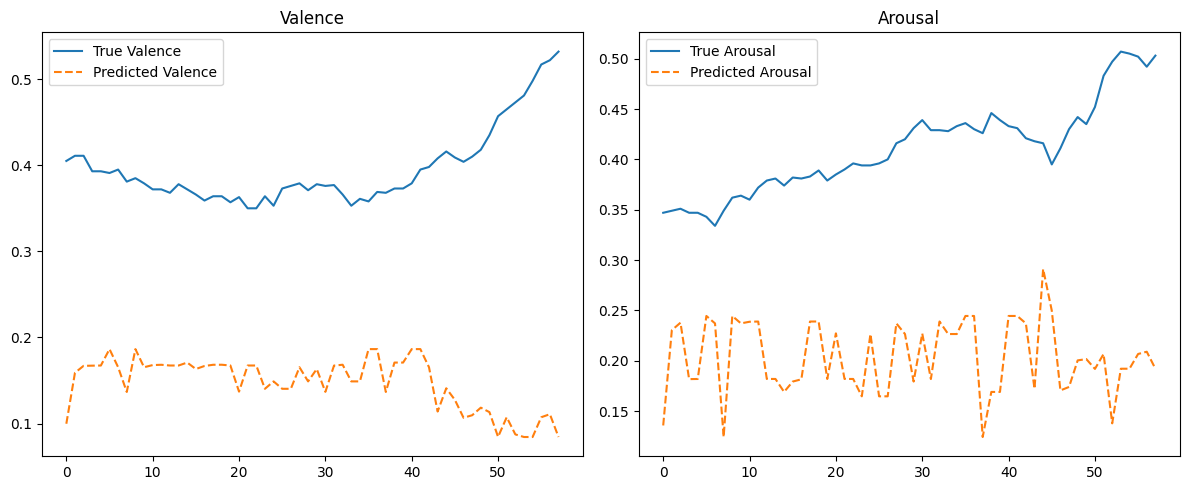

In [167]:
y_pred = model.predict(X_test)
evaluate_model(y_test, emotions_test, y_pred)

Wybór kilku cech wg artykułu - powiązane z energy i audspec

In [169]:
feature_cols = [col for col in df.columns if col not in ['song_id', 'valence', 'arousal', 'frameTime', 'emotion']]
# print(feature_cols) # energy, audspec
feature_cols = list(filter(lambda k: 'energy' in k or 'audspec' in k, feature_cols))
X, y, emotions = divide_into_sequences(df, feature_cols)
X_train, y_train, emotions_train, X_test, y_test, emotions_test = split_data(X, y, emotions)

model1 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(feature_cols))),
    TimeDistributed(Dense(32, activation='relu')),
    TimeDistributed(Dense(2))  # valence + arousal
])

model1.compile(optimizer='adam', loss='mse')
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0609 - val_loss: 0.0591
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0499 - val_loss: 0.0535
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0515 - val_loss: 0.0429
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0506 - val_loss: 0.0441
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0466 - val_loss: 0.0371
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0459 - val_loss: 0.0493
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0468 - val_loss: 0.0368
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0452 - val_loss: 0.0449
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0434 - val_loss: 0.0376
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0431 - val_loss: 0.0409
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0435 - val_loss: 0.0352
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0307
MSE Arousal: 0.0473
-------------------------------------
MAE Valence: 0.1427
MAE Arousal: 0.1760
-------------------------------------
R² Valence: 0.2302
R² Arousal: 0.0296
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        12
       happy       0.81      0.92      0.86        52
     relaxed       0.00      0.00      0.00         5
         sad       0.09      0.50      0.15         2

    accuracy                           0.69        71
   macro avg       0.23      0.36      0.25        71
weighted avg       0.60      0.69      0.64        71

['anger' 'happy' 'relaxed' 'sad']
['happy' 'relaxed' 'sad']
-------------------------------------
EVALUATION OF ONE SONG (SEQUENCE)

Results for probe no 3:
True emotion: happy
True valence: 0.3959, true arousal: 0

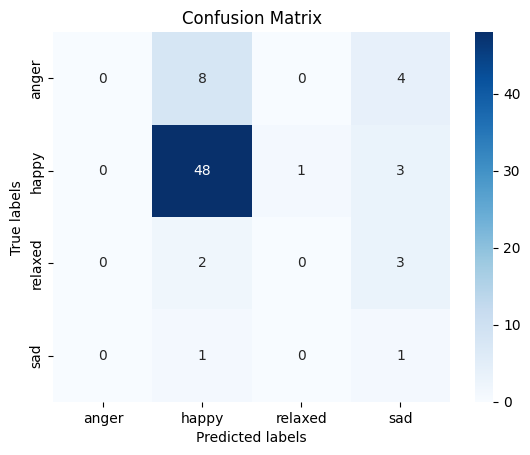

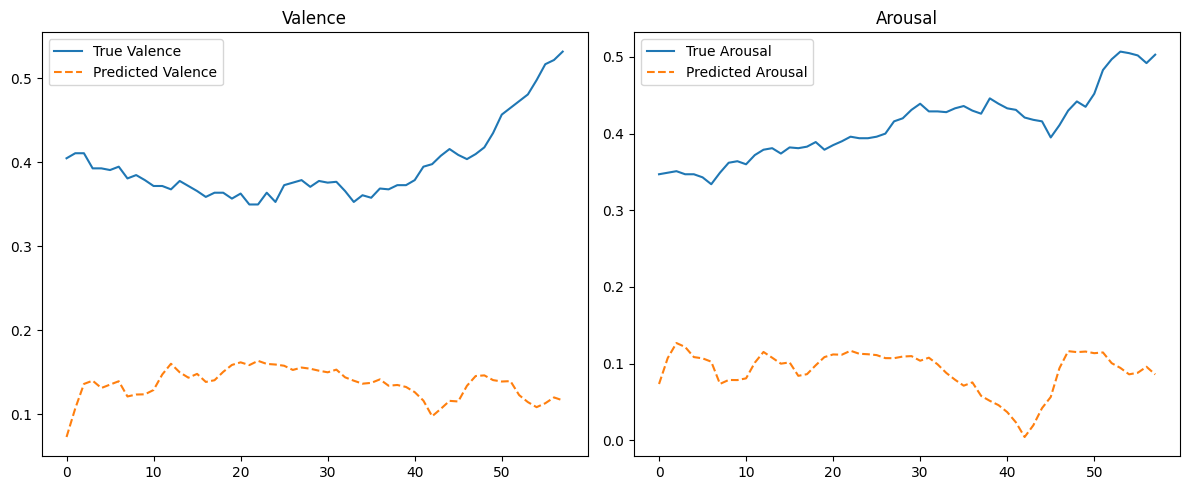

In [171]:
y_pred = model1.predict(X_test)
evaluate_model(y_test, emotions_test, y_pred)

Wybór cech za pomocą korelacji - szybka metoda

In [172]:
song_ids = df['song_id'].unique()
train_ids, test_ids = train_test_split(song_ids, test_size=0.2, random_state=42)

feature_cols = [col for col in df.columns if col not in ['song_id', 'valence', 'arousal', 'frameTime', 'emotion']]
df_train = df[df['song_id'].isin(train_ids)].copy()
X_train_flat = df_train[feature_cols]
y_train_valence_flat = df_train['valence']
y_train_arousal_flat = df_train['arousal']

corr_valence = X_train_flat.corrwith(y_train_valence_flat).abs()
corr_arousal = X_train_flat.corrwith(y_train_arousal_flat).abs()

top_valence = corr_valence.sort_values(ascending=False).head(30)
top_arousal = corr_arousal.sort_values(ascending=False).head(30)

# cechy wspólne
top_common = set(top_valence.index).intersection(top_arousal.index)
print(top_common)

{'audspec_lengthL1norm_sma_de_stddev', 'pcm_fftMag_spectralVariance_sma_amean', 'pcm_fftMag_spectralVariance_sma_stddev', 'pcm_fftMag_spectralVariance_sma_de_stddev', 'pcm_fftMag_spectralRollOff90.0_sma_de_stddev', 'logHNR_sma_de_stddev', 'pcm_fftMag_mfcc_sma[1]_amean', 'pcm_fftMag_spectralCentroid_sma_de_stddev', 'pcm_fftMag_spectralRollOff90.0_sma_stddev', 'voicingFinalUnclipped_sma_de_stddev', 'pcm_zcr_sma_de_stddev', 'pcm_fftMag_psySharpness_sma_de_stddev', 'pcm_fftMag_spectralFlux_sma_de_stddev'}


In [173]:
feature_cols = list(top_common)
X, y, emotions = divide_into_sequences(df, feature_cols)
X_train, y_train, emotions_train, X_test, y_test, emotions_test = split_data(X, y, emotions)

model2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(feature_cols))),
    TimeDistributed(Dense(32, activation='relu')),
    TimeDistributed(Dense(2))  # valence + arousal
])

model2.compile(optimizer='adam', loss='mse')
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.1214 - val_loss: 0.0783
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0740 - val_loss: 0.0706
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0678 - val_loss: 0.0747
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0692 - val_loss: 0.0819
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0700 - val_loss: 0.0765
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0654 - val_loss: 0.0760
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0643 - val_loss: 0.0769
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0658 - val_loss: 0.0769
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0630 - val_loss: 0.0777
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0667 - val_loss: 0.0722
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0654 - val_loss: 0.0705
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step
REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0437
MSE Arousal: 0.0980
-------------------------------------
MAE Valence: 0.1623
MAE Arousal: 0.2699
-------------------------------------
R² Valence: -0.0946
R² Arousal: -1.0088
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        12
       happy       0.72      0.96      0.83        52
     relaxed       0.00      0.00      0.00         5
         sad       0.00      0.00      0.00         2

    accuracy                           0.70        71
   macro avg       0.18      0.24      0.21        71
weighted avg       0.53      0.70      0.61        71

['anger' 'happy' 'relaxed' 'sad']
['anger' 'happy']
-------------------------------------
EVALUATION OF ONE SONG (SEQUENCE)

Results for probe no 3:
True emotion: happy
True valence: 0.3959, true arousal: 0.4104

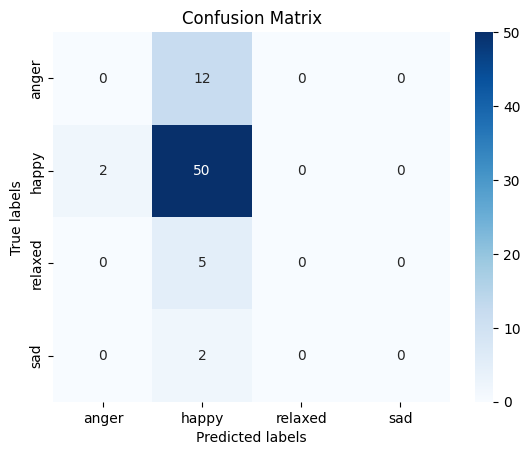

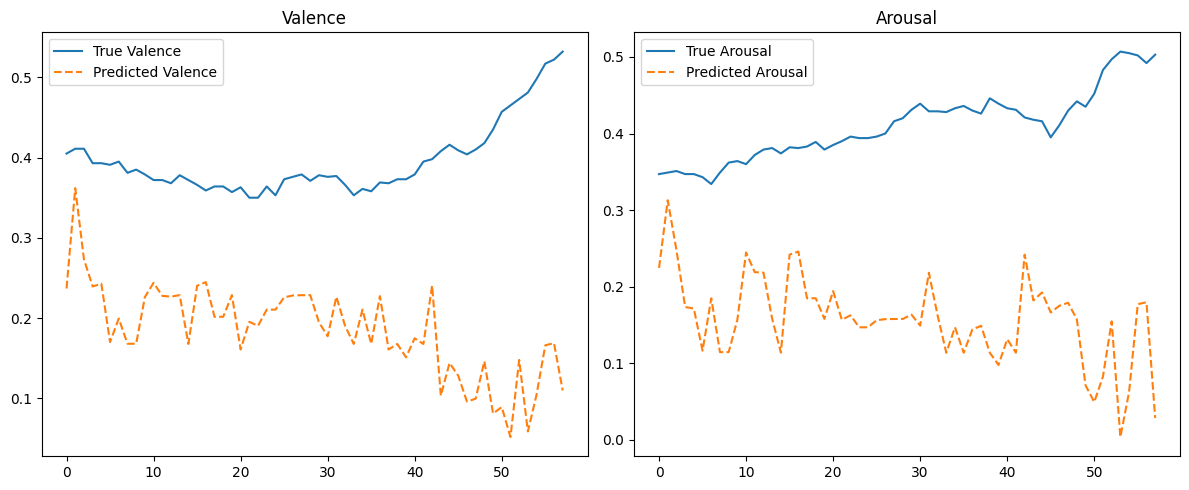

In [174]:
y_pred = model2.predict(X_test)
evaluate_model(y_test, emotions_test, y_pred)

Wybrane cechy na podstawie arykułu - powiązane z energy, audspec, zero crossing rate

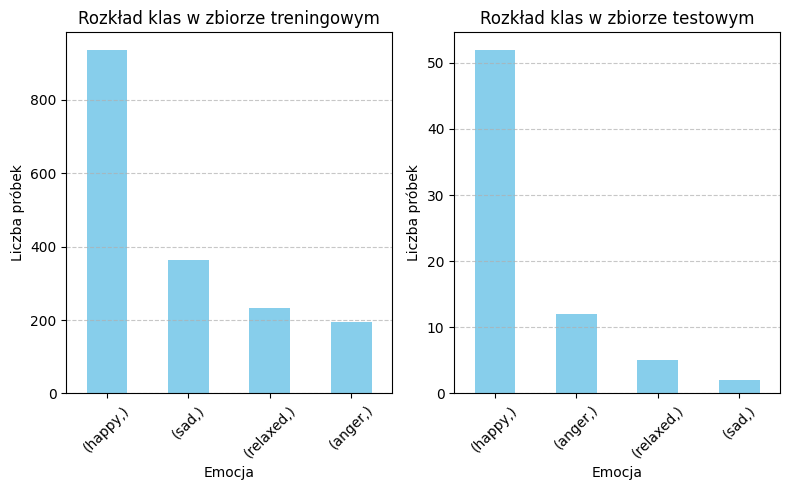

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0739 - val_loss: 0.0397
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0488 - val_loss: 0.0380
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0480 - val_loss: 0.0424
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0478 - val_loss: 0.0460
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0455 - val_loss: 0.0439
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0418 - val_loss: 0.0412
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0422 - val_loss: 0.0481
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0429 - val_loss: 0.0366
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0427 - val_loss: 0.0386
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0431 - val_loss: 0.0367
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0418 - val_loss: 0.0556
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0

In [187]:
feature_cols = [col for col in df.columns if col not in ['song_id', 'valence', 'arousal', 'frameTime', 'emotion']]
# print(feature_cols) # energy, audspec, zcr
feature_cols = list(filter(lambda k: 'energy' in k or 'audspec' in k or 'zcr' in k, feature_cols))
X, y, emotions = divide_into_sequences(df, feature_cols)
X_train, y_train, emotions_train, X_test, y_test, emotions_test = split_data(X, y, emotions)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
emotion_counts = pd.DataFrame(emotions_train).value_counts()
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Rozkład klas w zbiorze treningowym')
plt.xlabel('Emocja')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplot(1, 2, 2)
emotion_counts = pd.DataFrame(emotions_test).value_counts()
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Rozkład klas w zbiorze testowym')
plt.xlabel('Emocja')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

model3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(feature_cols))),
    TimeDistributed(Dense(32, activation='relu')),
    TimeDistributed(Dense(2))  # valence + arousal
])

model3.compile(optimizer='adam', loss='mse')
model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step
REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0304
MSE Arousal: 0.0444
-------------------------------------
MAE Valence: 0.1416
MAE Arousal: 0.1677
-------------------------------------
R² Valence: 0.2372
R² Arousal: 0.0905
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        12
       happy       0.80      0.92      0.86        52
     relaxed       0.00      0.00      0.00         5
         sad       0.10      0.50      0.17         2

    accuracy                           0.69        71
   macro avg       0.23      0.36      0.26        71
weighted avg       0.59      0.69      0.63        71

-------------------------------------
EVALUATION OF ONE SONG (SEQUENCE)

Results for probe no 3:
True emotion: happy
True valence: 0.3959, true arousal: 0.4104
Predicted emotion: happy
Predicted valence: 0.1985, p

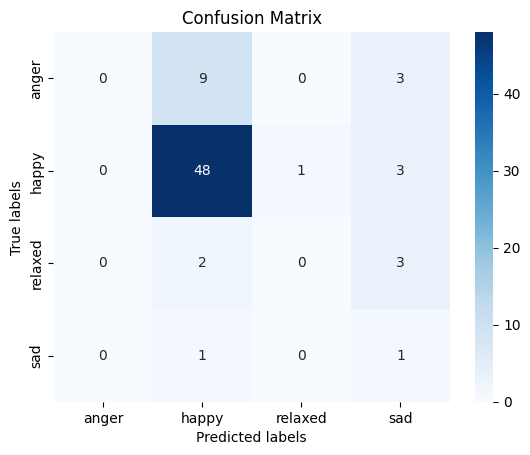

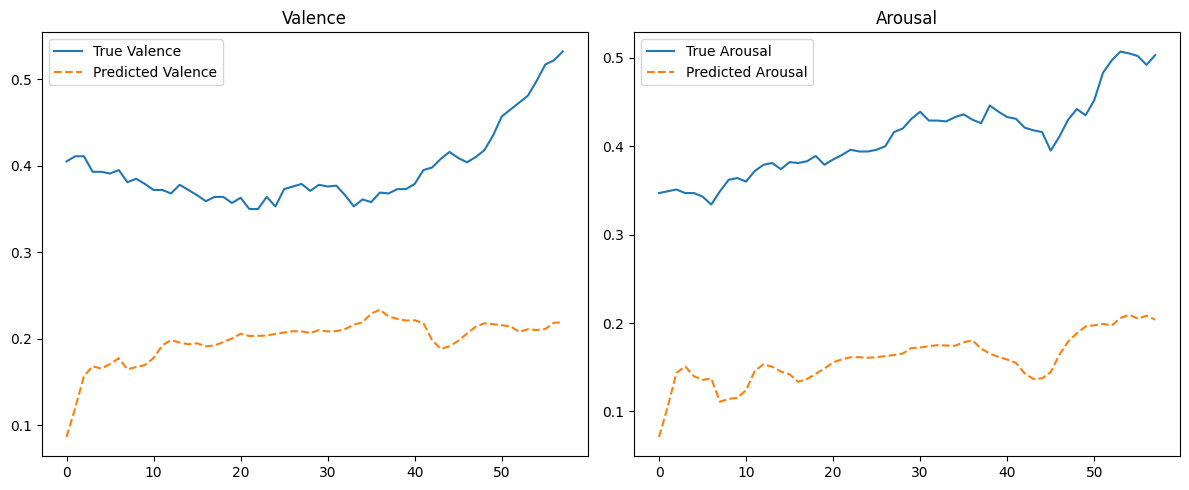

In [188]:
y_pred = model3.predict(X_test)
evaluate_model(y_test, emotions_test, y_pred)

Wszystkie te wyniki są bardzo niskie ze względu na nierównomierną ilość przykładów w klasach.

Ograniczenie ilości piosenek radosnych, aby zbiór był bardziej zrównoważony.
<br>
Wyniki są już lepsze, jednak model nie rozpoznaje emocji złości i zdecydowanie najbardziej myli się rozpoznając w większości przykładów emocję radości.

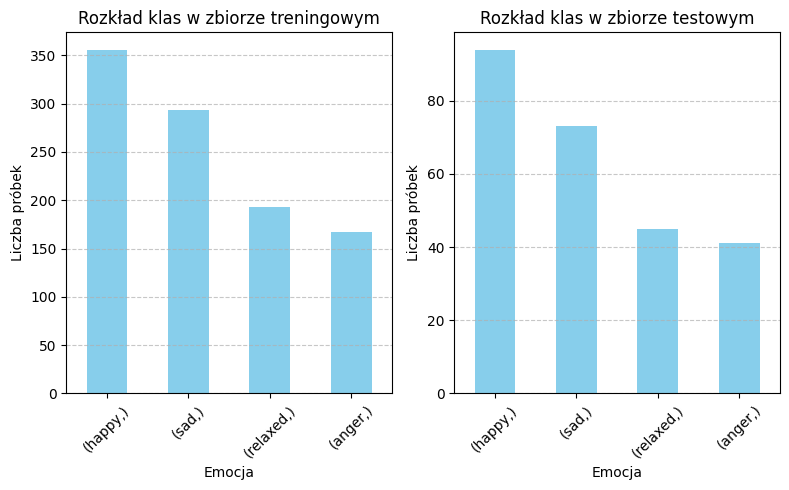

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0640 - val_loss: 0.0470
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0525 - val_loss: 0.0465
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0506 - val_loss: 0.0452
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0513 - val_loss: 0.0452
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0493 - val_loss: 0.0441
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0482 - val_loss: 0.0445
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0490 - val_loss: 0.0441
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0463 - val_loss: 0.0432
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0455 - val_loss: 0.0428
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0478 - val_loss: 0.0442
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0444 - val_loss: 0.0424
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0

In [201]:
feature_cols = [col for col in df.columns if col not in ['song_id', 'valence', 'arousal', 'frameTime', 'emotion']]
# print(feature_cols) # energy, audspec, zcr
feature_cols = list(filter(lambda k: 'energy' in k or 'audspec' in k or 'zcr' in k, feature_cols))
X, y, emotions, ids = divide_into_sequences(df, feature_cols)
X_train, y_train, emotions_train, X_test, y_test, emotions_test = split_data(X, y, emotions, ids)

model3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(feature_cols))),
    TimeDistributed(Dense(32, activation='relu')),
    TimeDistributed(Dense(2))  # valence + arousal
])

model3.compile(optimizer='adam', loss='mse')
model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0387
MSE Arousal: 0.0439
-------------------------------------
MAE Valence: 0.1540
MAE Arousal: 0.1715
-------------------------------------
R² Valence: 0.2095
R² Arousal: 0.4919
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        41
       happy       0.55      0.88      0.68        94
     relaxed       0.32      0.18      0.23        45
         sad       0.65      0.67      0.66        73

    accuracy                           0.55       253
   macro avg       0.38      0.43      0.39       253
weighted avg       0.45      0.55      0.48       253

-------------------------------------
EVALUATION OF ONE SONG (SEQUENCE)

Results for probe no 3:
True emotion: relaxed
True valence: 0.1676, true arousal: -0.0343
Predicted emotion: happy
Predicted valence: 0.0977

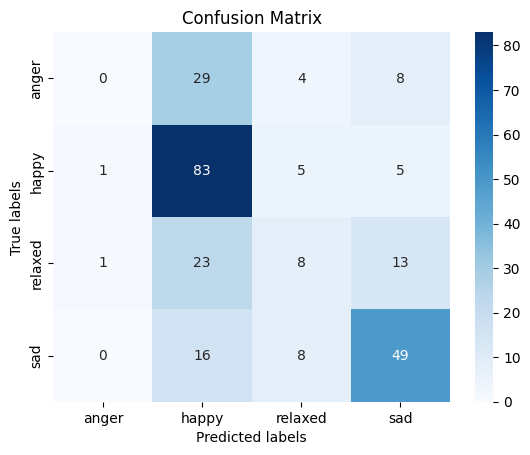

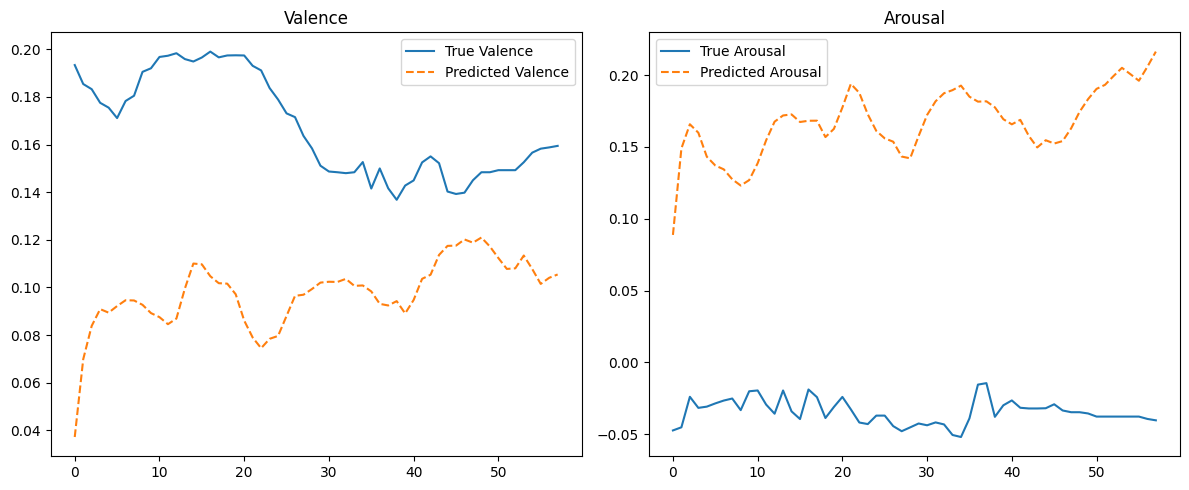

In [202]:
y_pred = model3.predict(X_test)
evaluate_model(y_test, emotions_test, y_pred)

Model z dostrojonymi hiperparametrami - wykrywa już wszystkie emocje w miarę równomiernie, jednak ogólne accuracy jest bardzo niskie (ok. 45%).

In [239]:
feature_cols = [col for col in df.columns if col not in ['song_id', 'valence', 'arousal', 'frameTime', 'emotion']]
# print(feature_cols) # energy, audspec, zcr
feature_cols = list(filter(lambda k: 'energy' in k or 'audspec' in k or 'zcr' in k, feature_cols))
X, y, emotions, ids = divide_into_sequences(df, feature_cols)

X_train, y_train, emotions_train, X_test, y_test, emotions_test = split_data(X, y, emotions, ids)

model4 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(feature_cols))),
    Dropout(0.2),
    # LSTM(64, return_sequences=True),
    # Dropout(0.3),
    TimeDistributed(Dense(32, activation='relu')),
    TimeDistributed(Dense(2))  # valence + arousal
])

model4.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
model4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0671 - val_loss: 0.0500
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0518 - val_loss: 0.0487
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0491 - val_loss: 0.0488
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0468 - val_loss: 0.0488
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0499 - val_loss: 0.0488
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0451 - val_loss: 0.0481
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0454 - val_loss: 0.0474
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0455 - val_loss: 0.0478
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0464 - val_loss: 0.0468
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0435 - val_loss: 0.0471
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0413 - val_loss: 0.0463
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0467
MSE Arousal: 0.0442
-------------------------------------
MAE Valence: 0.1745
MAE Arousal: 0.1711
-------------------------------------
R² Valence: 0.1350
R² Arousal: 0.4806
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       anger       0.33      0.12      0.17        43
       happy       0.46      0.79      0.58        68
     relaxed       0.44      0.26      0.33        54
         sad       0.57      0.58      0.58        74

    accuracy                           0.49       239
   macro avg       0.45      0.44      0.41       239
weighted avg       0.47      0.49      0.45       239

-------------------------------------
EVALUATION OF ONE SONG (SEQUENCE)

Results for probe no 3:
True emotion: happy
True valence: 0.1319, true arousal: 0.3376
Predicted emotion: happy
Predicted valence: 0.1431, pr

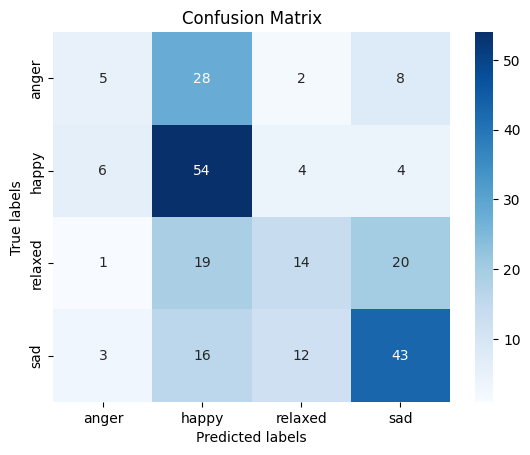

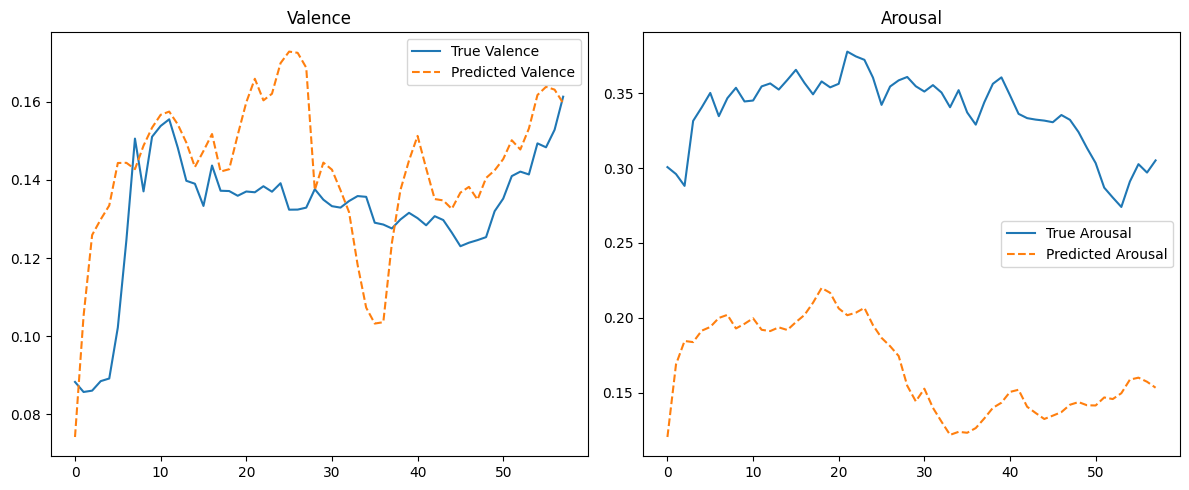

In [240]:
y_pred = model4.predict(X_test)
evaluate_model(y_test, emotions_test, y_pred)

Bidirectional LSTM - nie ma znacznej poprawy

In [227]:
feature_cols = [col for col in df.columns if col not in ['song_id', 'valence', 'arousal', 'frameTime', 'emotion']]
# print(feature_cols) # energy, audspec, zcr
feature_cols = list(filter(lambda k: 'energy' in k or 'audspec' in k or 'zcr' in k, feature_cols))
X, y, emotions, ids = divide_into_sequences(df, feature_cols)

X_train, y_train, emotions_train, X_test, y_test, emotions_test = split_data(X, y, emotions, ids)

model5 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(sequence_length, len(feature_cols)))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    TimeDistributed(Dense(32, activation='relu')),
    TimeDistributed(Dense(2))  # valence + arousal
])

model5.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
model5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.0785 - val_loss: 0.0535
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0577 - val_loss: 0.0505
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0534 - val_loss: 0.0490
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0494 - val_loss: 0.0508
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0503 - val_loss: 0.0487
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0465 - val_loss: 0.0484
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0453 - val_loss: 0.0495
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0456 - val_loss: 0.0481
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0474 - val_loss: 0.0479
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0472 - val_loss: 0.0476
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0466
MSE Arousal: 0.0431
-------------------------------------
MAE Valence: 0.1726
MAE Arousal: 0.1692
-------------------------------------
R² Valence: 0.1378
R² Arousal: 0.4938
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       anger       0.23      0.07      0.11        43
       happy       0.49      0.78      0.60        68
     relaxed       0.29      0.09      0.14        54
         sad       0.52      0.72      0.61        74

    accuracy                           0.48       239
   macro avg       0.39      0.41      0.36       239
weighted avg       0.41      0.48      0.41       239

-------------------------------------
EVALUATION OF ONE SONG (SEQUENCE)

Results for probe no 3:
True emotion: happy
True valence: 0.1319, true arousal: 0.3376
Predicted emotion: happy
Predicted valence: 0.1469, p

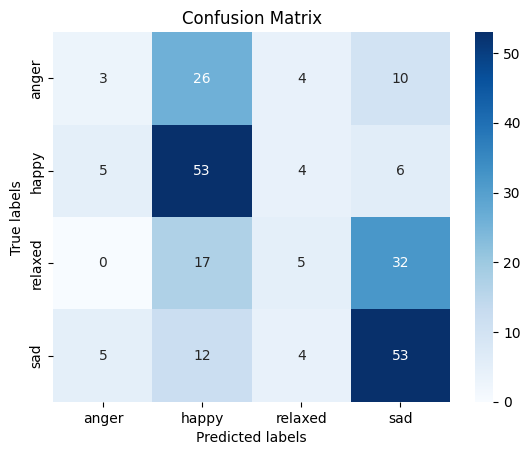

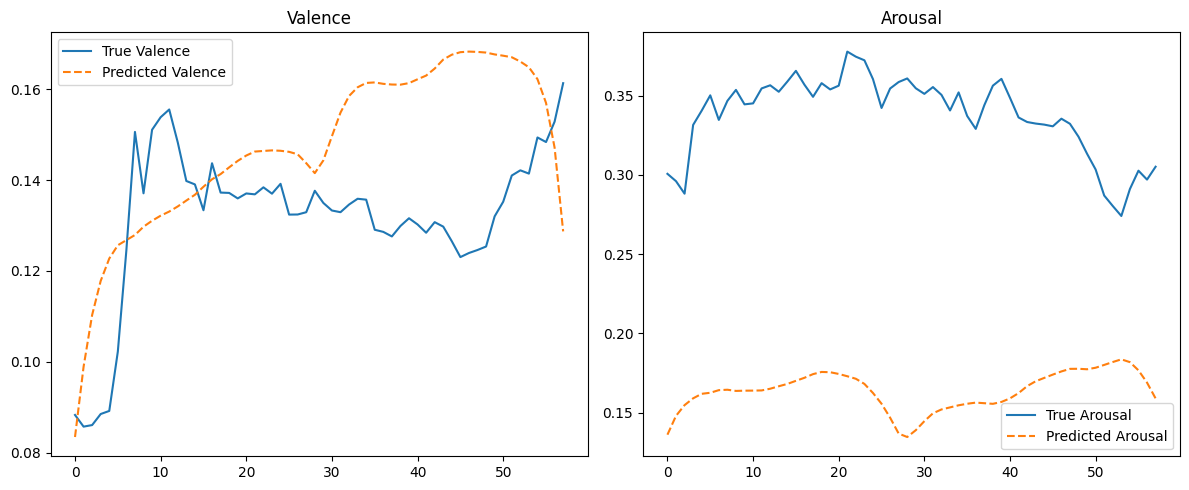

In [228]:
y_pred = model5.predict(X_test)
evaluate_model(y_test, emotions_test, y_pred)

Przechodzimy do kolejnego etapu eksperymentu - klasyfikacja na podstawie tych samych cech.

In [5]:
def split_data_class(dataframe, feature_cols):
    dataframe = dataframe.dropna()
    X = np.array(dataframe[feature_cols])
    y = np.array(dataframe[['emotion']])

    song_ids = np.array(dataframe['song_id'])
    train_ids, test_ids = train_test_split(dataframe['song_id'].unique(), test_size=0.2, random_state=42)

    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(len(X)):
        seq_song_id = song_ids[i]
        if seq_song_id in train_ids:
            X_train.append(X[i])
            y_train.append(y[i])
        else:
            X_test.append(X[i])
            y_test.append(y[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    return X_train, y_train, X_test, y_test

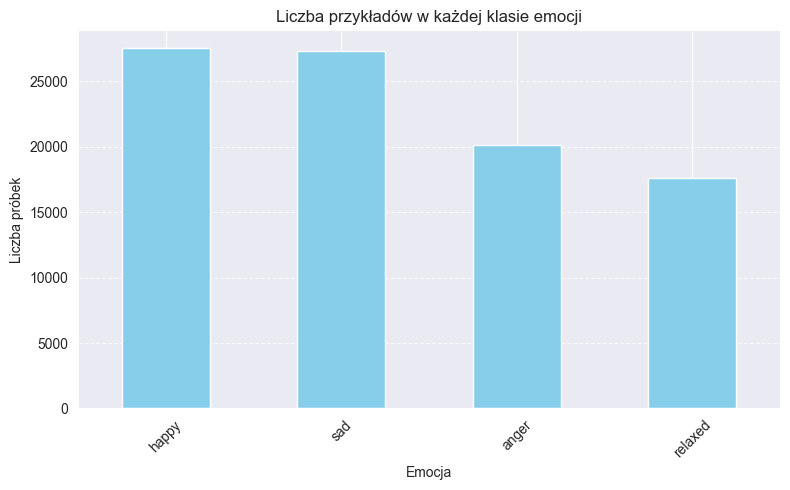

In [6]:
feature_cols = [col for col in df.columns if col not in ['song_id', 'valence', 'arousal', 'frameTime', 'emotion']]
# print(feature_cols) # energy, audspec, zcr
feature_cols = list(filter(lambda k: 'energy' in k or 'audspec' in k or 'zcr' in k, feature_cols))

happy_indices = df[df['emotion'] == 'happy'].index
df_small = df.drop(index=happy_indices[::2]).reset_index(drop=True)
happy_indices = df_small[df_small['emotion'] == 'happy'].index
df_small = df_small.drop(index=happy_indices[::2][::4]).reset_index(drop=True)

emotion_counts = df_small['emotion'].value_counts()
plt.figure(figsize=(8, 5))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Liczba przykładów w każdej klasie emocji')
plt.xlabel('Emocja')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Wyniki dla różnych modeli klasyfikacji na podstawie wybranych najważniejszych cech dla porównania z regresją - wyświetlone accuracy.

In [11]:
X_train, y_train, X_test, y_test = split_data_class(df_small, feature_cols)

clf = RandomForestClassifier(n_estimators=10, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
# clf = RandomForestClassifier(n_estimators=20, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.32      0.14      0.20      2730
       happy       0.55      0.61      0.57      5577
     relaxed       0.17      0.05      0.08      2609
         sad       0.48      0.77      0.59      4685

    accuracy                           0.48     15601
   macro avg       0.38      0.39      0.36     15601
weighted avg       0.43      0.48      0.43     15601

0.48003333119671815


In [7]:
X_train, y_train, X_test, y_test = split_data_class(df_small, feature_cols)

le = LabelEncoder()
# Zakoduj etykiety na liczby
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [13]:
param_dist = {'C': [0.3, 0.5, 0.7]}
rand = RandomizedSearchCV(SVC(kernel='linear'), param_dist, n_iter=3, cv=5, n_jobs=-1)
rand.fit(X_train, y_train_encoded)
print(rand.best_params_)
print(rand.best_score_)

{'C': 0.5}
0.4638160974352087


In [18]:
knn_grid = {
    'n_neighbors': [150, 200, 300],
}
rand = RandomizedSearchCV(KNeighborsClassifier(), knn_grid, n_iter=3, cv=5, n_jobs=-1)
rand.fit(X_train, y_train_encoded)
print(rand.best_params_)
print(rand.best_score_)

{'n_neighbors': 200}
0.4283143804025463


In [13]:
lda_grid = {
    'solver': ['svd', 'lsqr']
}
lda = GridSearchCV(LinearDiscriminantAnalysis(), lda_grid, cv=5)
lda.fit(X_train, y_train_encoded)
best_lda = lda.best_estimator_

In [20]:
print(best_lda)

LinearDiscriminantAnalysis()


MedianVotingClassifier na podstawie artykułu

In [19]:
class MedianVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers):
        self.classifiers = classifiers

    def fit(self, X, y):
        self.models_ = [clone(clf).fit(X, y) for clf in self.classifiers]
        return self

    def predict(self, X):
        all_preds = np.asarray([model.predict(X) for model in self.models_])
        return np.median(all_preds, axis=0).round().astype(int)  # zakłada klasy 0,1,2,...

# Przygotuj modele
models = [
    SVC(C=0.5, kernel='linear', probability=False),
    NearestCentroid(),
    KNeighborsClassifier(n_neighbors=200),
    GaussianNB(),
    LinearDiscriminantAnalysis()
]

# Klasyfikator głosujący
voter = MedianVotingClassifier(models)
voter.fit(X_train, y_train_encoded)
y_pred = voter.predict(X_test)

y_pred_decoded = le.inverse_transform(y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred_decoded))
print(classification_report(y_test, y_pred_decoded))

Accuracy: 0.4767002115249023
              precision    recall  f1-score   support

       anger       0.34      0.23      0.27      2730
       happy       0.59      0.53      0.56      5577
     relaxed       0.19      0.07      0.11      2609
         sad       0.48      0.78      0.59      4685

    accuracy                           0.48     15601
   macro avg       0.40      0.40      0.38     15601
weighted avg       0.44      0.48      0.44     15601



Wszystkie wyniki są bardzo podobne - przede wszystkim niskie. Wybrane podejście - rozpoznawanie wielu wartości na utwór (dynamiczne) za pomocą wielu cech, które zostały wcześniej wyekstraktowane, nie sprawdza się.